## Creacion y solucion del sistema  formado por:

$-\delta_{n,\sigma} = -(w-E_0+i\eta)g^r_{n,\xi\sigma} + \gamma\left(
e^{i\theta}g^r_{n+(N+1),\xi\sigma}+e^{-i\theta}g^r_{n+(N-1),\xi\sigma}\right) + \frac{i\lambda_{EO}}{2}\nu\xi g^r_{n+(N+2),\xi\sigma} + \frac{i\lambda_R}{2}e^{-i\xi\sigma\psi}\left(g^r_{n+(N-1),-\xi\sigma}-g^r_{n+(N+1),-\xi\sigma}
\right)$

con el argumento de periodicidad:  $g^r_{N+n,\xi\sigma}=g^r_{n,\xi\sigma}$


Veamos cada los valores que acompanan a cada termino por separado:

$(t_0) \rightarrow g^r_{n,\xi\sigma}$

$(t_1) \rightarrow g^r_{n+(N+1),\xi\sigma}$ 

$(t_2) \rightarrow g^r_{n+(N-1),\xi\sigma}$ 

$(t_3) \rightarrow g^r_{n+(N+2),\xi\sigma}$ 

$(t_4) \rightarrow g^r_{n+(N-1),-\xi\sigma}$ 

$(t_5) \rightarrow g^r_{n+(N+1),-\xi\sigma}$

El punto es crear un sistema algebraico del tipo $Ag^r=B$ y resolver para $g^r$

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from time import time
from scipy.sparse.linalg import spsolve
from scipy import sparse
from scipy.integrate import simps, trapz

In [2]:
N = 4 # numero de sitios
gamma = 1
theta = 0
nu = 1
l_R = 0
l_EO = 0
sigma = 1
E0 = 0
KbT = 1
w = 1
eta = 1.0E-4
e = 1
c = 1
h = 1
phi_0 = c*h/e
phi = phi_0/N
theta = 2*np.pi*phi/N
psi = 2*np.pi/N
mu = 1


In [3]:
def fila(n,xi,w,theta,psi):
    '''
    Esta función crea cada fila (cada ecuación)
    n indica el sitio en cuestión
    '''
    A = np.zeros(2*N,dtype=complex)
    # evaluemos cada termino
    if xi==1: i = 0
    else: i = N
    A[n-1+i] += -(w-E0+eta*1.0j) # t0
    k = N+1
    l = (n+k)%N
    if(l==0): l=N 
    A[l-1+i] += gamma*np.exp(theta*1j) # t1
    k = N-1
    l = (n+k)%N
    if(l==0): l=N 
    A[l-1+i] += gamma*np.exp(-theta*1j) # t2 
    k = N+2
    l = (n+k)%N
    if(l==0): l=N 
    A[l-1+i] += l_EO*nu*xi*0.5j # t3
    if xi==1: i = N
    else: i = 0
    k = N-1
    l = (n+k)%N
    if(l==0): l=N 
    A[l-1+i] += l_R*np.exp(-xi*sigma*psi*1j)*0.5j  # t4
    k = N+1
    l = (n+k)%N
    if(l==0): l=N
    A[l-1+i] += -l_R*np.exp(-xi*sigma*psi*1j)*0.5j # t5    
    return A

def matrix_A(w,theta,psi):
    '''
    Esta función crea la matriz completa con los valores de xi=1 
    y luego con los valores de xi=-1, en ese orden
    '''
    A = np.matrix(np.empty(shape=(0,2*N), dtype=complex))
    for n in range(1,N+1):  
        a1 = fila(n,1,w,theta,psi)
        A = np.insert(A,(n-1),a1,axis=0)
    for n in range(1,N+1):  
        a1 = fila(n,-1,w,theta,psi)
        A = np.insert(A,(n-1)+N,a1,axis=0)
    A1 = sparse.csr_matrix(A)
    return A1


A = matrix_A(w,theta,psi)
#print(A)

B = np.zeros(2*N,dtype=complex)
B[0] = -1

# Calculo de la densidad de Corriente J


$J_c = ie\left[2i\gamma \mathcal{I}\left(e^{i\theta}(-ig^{<}_{2,\sigma})\right) 
+\lambda_{EO}\nu_n\sigma g^{<}_{3,\sigma} +2i\lambda_R \mathcal{R}\left(
e^{-i\sigma\psi}\left(-ig^{<}_{2,(-\sigma)}\right)\right)\right]$

con 

$g^{<}(w)=\frac{2i\mathcal{I}(g^r)}{e^{\beta w}+1}$

En este caso tomare como $g^r$ los obtenidos numericamente de la resolucion del sistema AG=B


In [4]:
def den_corr(G,w,theta,psi):
    '''
    Calculo de la densidad de corriente
    '''
    g21 = 2j*G[1].imag/(np.exp(w/KbT)+1) # G[2,1]
    g31 = 2j*G[2].imag/(np.exp(w/KbT)+1) # G[3,1]
    g2_1 = 2j*G[N+1].imag/(np.exp(w/KbT)+1) # G[2,-1]
    t1 = -1.0j*np.exp(-1j*theta)*g21
    t2 = -1.0j*np.exp(-1j*sigma*psi)*g2_1
    Jc = (1j*e)*(2j*gamma*t1.imag + l_EO*nu*sigma*g31 + 2j*l_R*t2.real)
    return Jc

## Densidad espectral

$
\rho(w) = -\frac{1}{\pi}\mathcal{I}(g^r_{1,1})
$



In [5]:
def den_espectral(G):
    return -G[0].imag/np.pi


- - - 
## Grafiquemos $\rho(w)$ vs $w$

In [6]:

def rho_w(w_0,w_f,nw):
    w1 = np.linspace(w_0,w_f,nw)
    Den = np.array([],dtype=complex)
    for w in w1:
        A = matrix_A(w,theta,psi)       # creamos la matriz A
        B = np.zeros(2*N,dtype=complex) # creamos el vector B
        B[0] = -1
        #G = np.dot(np.linalg.inv(A),B)  # Resolvemos el sistema AG=B
        G = spsolve(A,B)
        G = np.asarray(G).ravel()
        Den = np.append(Den,den_espectral(G)) # calculamos densidad espectral
    return w1, Den


Elapsed time: 1.0108022690 seconds.


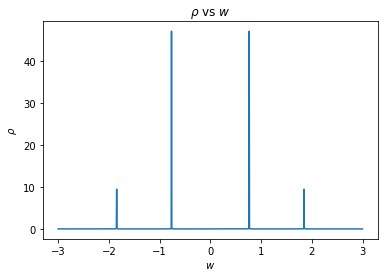

In [7]:
l_R = 0.0
l_EO = 0.0

start_time = time()

w1,Den_esp = rho_w(-3,3,1000)
plt.plot(w1,Den_esp.real) # grafico la densidad espectral
plt.title("$\\rho$ vs $w$")
plt.xlabel("$w$")
plt.ylabel("$\\rho$")

elapsed_time = time() - start_time
print("Elapsed time: %.10f seconds." % elapsed_time)


## Grafiquemos $J_c(w)$ vs $w$

In [8]:

def Jc_w(w_0,w_f,nw):
    w1 = np.linspace(w_0,w_f,nw)
    Jc = np.array([],dtype=complex)
    for w in w1:
        A = matrix_A(w,theta,psi)       # creamos la matriz A
        B = np.zeros(2*N,dtype=complex) # creamos el vector B
        B[0] = -1
        #G = np.dot(np.linalg.inv(A),B)  # Resolvemos el sistema AG=B
        G = spsolve(A,B)
        G = np.asarray(G).ravel()
        Jc = np.append(Jc,den_corr(G,w,theta,psi)) # calculamos densidad espectral
    return w1, Jc


Elapsed time: 4.7815301418 seconds.


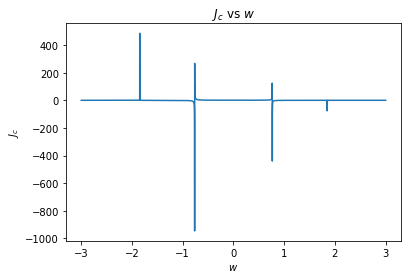

In [9]:
l_R = 0.0
l_EO = 0.0

start_time = time()

w1,Den_corr = Jc_w(-3,3,5001)
plt.plot(w1,Den_corr.real) # grafico la densidad de corriente
plt.title("$J_c$ vs $w$")
plt.xlabel("$w$")
plt.ylabel("$J_c$")
elapsed_time = time() - start_time
print("Elapsed time: %.10f seconds." % elapsed_time)

## Calculo de la corriente

$I(\phi)=\int_{-\infty}^{\mu}Jc(w)dw$

In [12]:
mu = 0.0
def corriente(p_0,p_f,n_p):
    p1 = np.linspace(p_0,p_f,n_p)
    I1 = np.array([],dtype=float)
    for psi in p1: 
        w1,Den_corr = Jc_w(-3,mu,1001)
        I1 = np.append(I1,simps(Den_corr.real,w1))
        #I1 = np.append(I1,trapz(Den_corr.real,w1))
        #print(psi,I1[-1])
    return p1,I1
    
    

In [13]:
p,I = corriente(-1.0,1.0,10)